# Cluster similar regions ~~on a hexgrid~~ based on Voronoi

In [1]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import libpysal
import spopt
import h3
import matplotlib.pyplot as plt
from libpysal import graph
from scipy.spatial import distance
from clustergram import Clustergram
from bokeh.io import output_notebook
from bokeh.plotting import show
from sklearn import cluster
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate

import preprocess_data

Retrieve building dataset and levels of clusters

In [2]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-ulce/boundaries_of_change/classification/")

Show area of interest (Central Europe sans Hungary)

<Axes: >

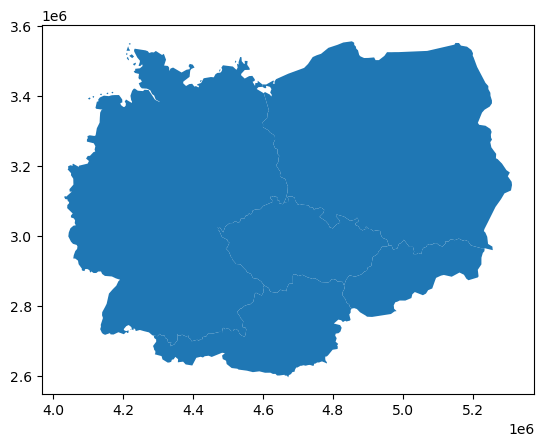

In [3]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi.plot()

# Hexes (old)

Hexify AOI

In [110]:
hexed = h3fy(aoi, resolution=3)

/home/dancejod/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'aoi_hexed')

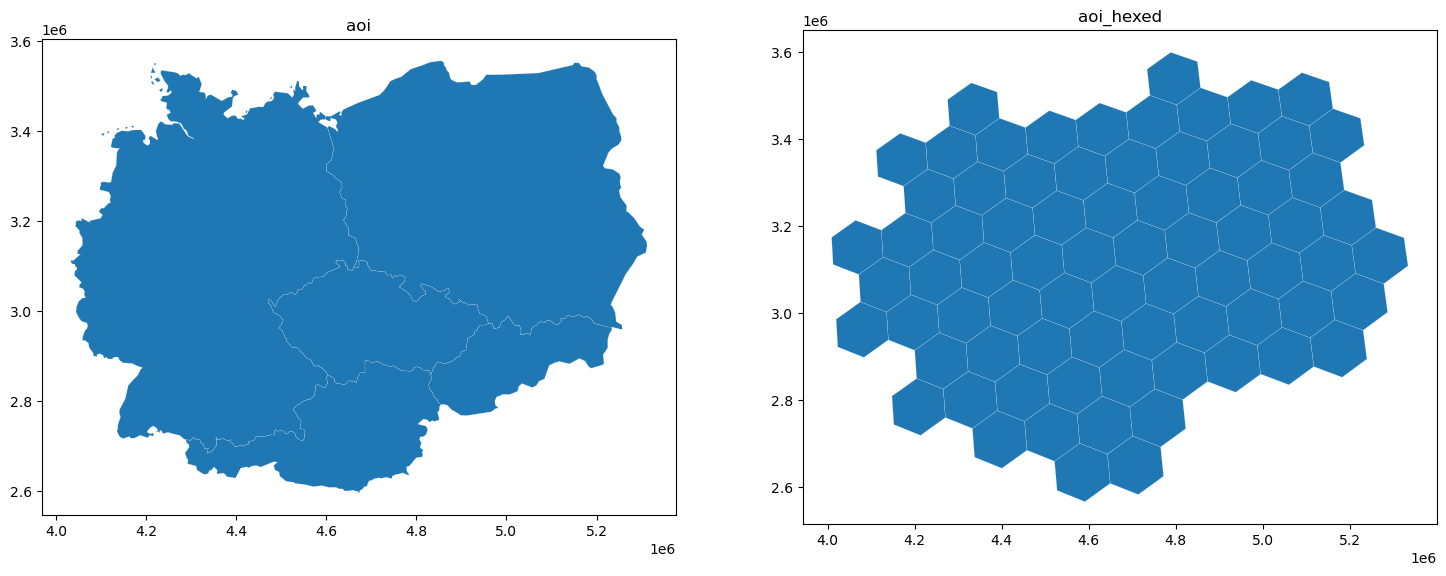

In [111]:
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

aoi.plot(ax=axs[0], linewidth=0.1, edgecolor='white')
hexed.plot(ax=axs[1], linewidth=0.1, edgecolor='white')

axs[0].set_title('aoi')
axs[1].set_title('aoi_hexed')

In [112]:
hexed

geometry
hex_id                                                            
831f52fffffffff  POLYGON ((4948900.827 3247639.141, 5012283.856...
831fabfffffffff  POLYGON ((4322580.144 2865573.857, 4384564.554...
831f88fffffffff  POLYGON ((4400275.867 2642932.21, 4457929.792 ...
831e2afffffffff  POLYGON ((5108691.228 2942641.52, 5165268.677 ...
831f55fffffffff  POLYGON ((5152245.191 3530387.501, 5089637.06 ...
...                                                            ...
831f8cfffffffff  POLYGON ((4270425.806 2759403.495, 4332499.017...
831f13fffffffff  POLYGON ((4238285.619 3207119.268, 4242747.672...
831e31fffffffff  POLYGON ((4801848.552 2932456.398, 4794938.941...
831f03fffffffff  POLYGON ((4569841.748 3443276.96, 4509240.905 ...
831e21fffffffff  POLYGON ((4948900.827 3247639.141, 4893187.384...

[75 rows x 1 columns]

In [113]:
hexed.index.name = "NAME"

Join buildings dataset with the hexgrid on a specified hierarchy level

In [114]:
# def join_buildings_with_grid(level):
#     joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
#     data = joined.groupby("NAME")[level].value_counts().unstack().fillna(0)
#     data_norm = preprocess_data.normalize_building_counts(data)

#     return data_norm.T

In [115]:
joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
data = joined.groupby("NAME")["level_4"].value_counts().unstack().fillna(0)
X = data.values / data.sum(axis=1).values[:, np.newaxis]
X

array([[2.25510871e-01, 2.16836651e-01, 1.66838684e-01, ...,
        2.24960615e-03, 0.00000000e+00, 0.00000000e+00],
       [1.57586462e-01, 2.79330247e-01, 1.59256385e-01, ...,
        6.22117555e-03, 0.00000000e+00, 0.00000000e+00],
       [9.77363630e-02, 3.51186295e-02, 6.63049244e-02, ...,
        8.52698731e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.45269175e-01, 2.25244610e-01, 2.21318252e-01, ...,
        1.23166734e-02, 0.00000000e+00, 0.00000000e+00],
       [1.37583734e-01, 2.39451807e-01, 1.56201975e-01, ...,
        4.73605085e-02, 0.00000000e+00, 0.00000000e+00],
       [9.15245259e-02, 1.12642085e-01, 2.13284384e-01, ...,
        3.31146809e-02, 1.49580907e-04, 0.00000000e+00]], shape=(75, 16))

In [116]:
data

level_4                6         8         4         15        12         1   \
NAME                                                                           
831e00fffffffff  227455.0  218706.0  168277.0  106557.0   81110.0    58583.0   
831e01fffffffff   88328.0  156566.0   89264.0   42449.0   43560.0    35775.0   
831e04fffffffff   68176.0   24497.0   46251.0   24761.0  175930.0   129586.0   
831e05fffffffff  140538.0  102209.0   88807.0  120873.0  276390.0    51442.0   
831e06fffffffff   88149.0   70683.0  191304.0   53473.0   64197.0   211170.0   
...                   ...       ...       ...       ...       ...        ...   
831faafffffffff  379255.0  283339.0  531625.0   80329.0   28884.0   596102.0   
831fabfffffffff  265781.0  472250.0  243451.0   39197.0   20056.0   265408.0   
831facfffffffff  214554.0  332673.0  326874.0   32160.0   11190.0   268749.0   
831fadfffffffff  189347.0  329541.0  214970.0  101476.0   14883.0   332718.0   
831faefffffffff  274731.0  338120.0  640220.0   65722.0   15163.0  1146503.0   

level_4                13       14       17       7        11        5   \
NAME                                                                      
831e00fffffffff   52171.0  46884.0  14790.0  11274.0   8797.0    8223.0   
831e01fffffffff   32493.0  43825.0   5047.0   5068.0  10492.0    4151.0   
831e04fffffffff  150540.0   2821.0  18004.0  49136.0    238.0    1662.0   
831e05fffffffff  318297.0  24808.0  25332.0  16422.0  20867.0    3050.0   
831e06fffffffff   98289.0   8502.0  13047.0  92769.0   5213.0   15476.0   
...                   ...      ...      ...      ...      ...       ...   
831faafffffffff   60928.0    716.0   2818.0  50284.0    646.0  449597.0   
831fabfffffffff  112619.0   1816.0   1619.0  35090.0    308.0  190403.0   
831facfffffffff   32917.0    537.0   1366.0  26297.0    177.0  211256.0   
831fadfffffffff   49536.0   5163.0   9413.0   7079.0    156.0   56770.0   
831faefffffffff   18309.0   2947.0  11469.0  27104.0      0.0  361398.0   

level_4              10       2      3    9   
NAME                                          
831e00fffffffff  3525.0   2269.0    0.0  0.0  
831e01fffffffff     0.0   3487.0    0.0  0.0  
831e04fffffffff     0.0   5948.0    0.0  0.0  
831e05fffffffff    76.0   1267.0    0.0  0.0  
831e06fffffffff     0.0  57727.0    0.0  0.0  
...                 ...      ...    ...  ...  
831faafffffffff    77.0  30665.0   96.0  0.0  
831fabfffffffff     0.0  27666.0    0.0  0.0  
831facfffffffff     0.0  18191.0    0.0  0.0  
831fadfffffffff     0.0  65179.0    0.0  0.0  
831faefffffffff   184.0  99401.0  449.0  0.0  

[75 rows x 16 columns]

Build a contiguity graph and perform an example agglomerative clustering using Bray–Curtis distance

In [117]:
%%time
queen = graph.Graph.build_contiguity(hexed)
agg = cluster.AgglomerativeClustering(n_clusters=6, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete')
agg.fit(X)

CPU times: user 4.92 ms, sys: 91 μs, total: 5.01 ms
Wall time: 4.82 ms


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse array of dtype 'float64'
	with 376 stored elements and shape (75, 75)>,
                        linkage='complete',
                        metric=<function braycurtis at 0x70067a8f20c0>,
                        n_clusters=6)

In [118]:
hexed[['geometry']].explore(agg.labels_, categorical=True, tiles="CartoDB Positron")

Try different numbers of clusters and create a clustergram

In [119]:
clusters = range(1,17)
labels_dict = {}

for k in clusters:
    labels_dict[k] = cluster.AgglomerativeClustering(n_clusters=k, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete').fit_predict(X)
labels = pd.DataFrame(labels_dict)
labels

1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0    0   1   1   1   4   4   4   4   4   1   1   0   0   0   2   2
1    0   0   0   0   1   1   1   0   2   2   0   1   1   1   1   0
2    0   0   0   0   1   1   1   0   2   2   0  11  11  11  11  11
3    0   0   0   0   1   1   1   0   8   8   8   8   8   8   8   8
4    0   1   1   1   4   4   4   4   4   1   1   0   0   0  14  14
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
70   0   0   0   0   1   1   1   0   2   2   0   1   1   1   1   0
71   0   0   0   0   0   0   0   1   1   0   4   4   4   4   4   4
72   0   0   0   0   0   0   0   3   3   3   3   3   3   3   3   1
73   0   0   0   3   3   3   3   7   7   7   7   7   7   7   7   7
74   0   1   1   1   4   4   4   4   4   1   1   0   5   5   5   5

[75 rows x 16 columns]

<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

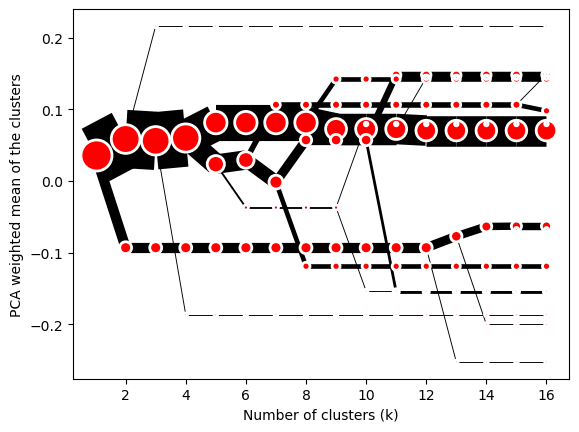

In [120]:
cgram = Clustergram.from_data(X, labels)
cgram.plot()

In [121]:
output_notebook()

Loading BokehJS ...

In [122]:
fig = cgram.bokeh()
show(fig)

Plot clusterized hexagons

In [123]:
def plot_cluster_maps(show_borders=False):
    fig, axs = plt.subplots(figsize=(15,10), nrows=4, ncols=4)
    axs = axs.flatten()
    
    for cluster, ax in zip(labels, axs):
        if show_borders:
            aoi.boundary.plot(ax=ax, color="maroon")
        hexed[["geometry"]].plot(labels[cluster].to_numpy(), ax=ax, categorical=True, cmap='tab20')
        ax.set_title(f"Number of clusters: {cluster}")
    
    plt.tight_layout()

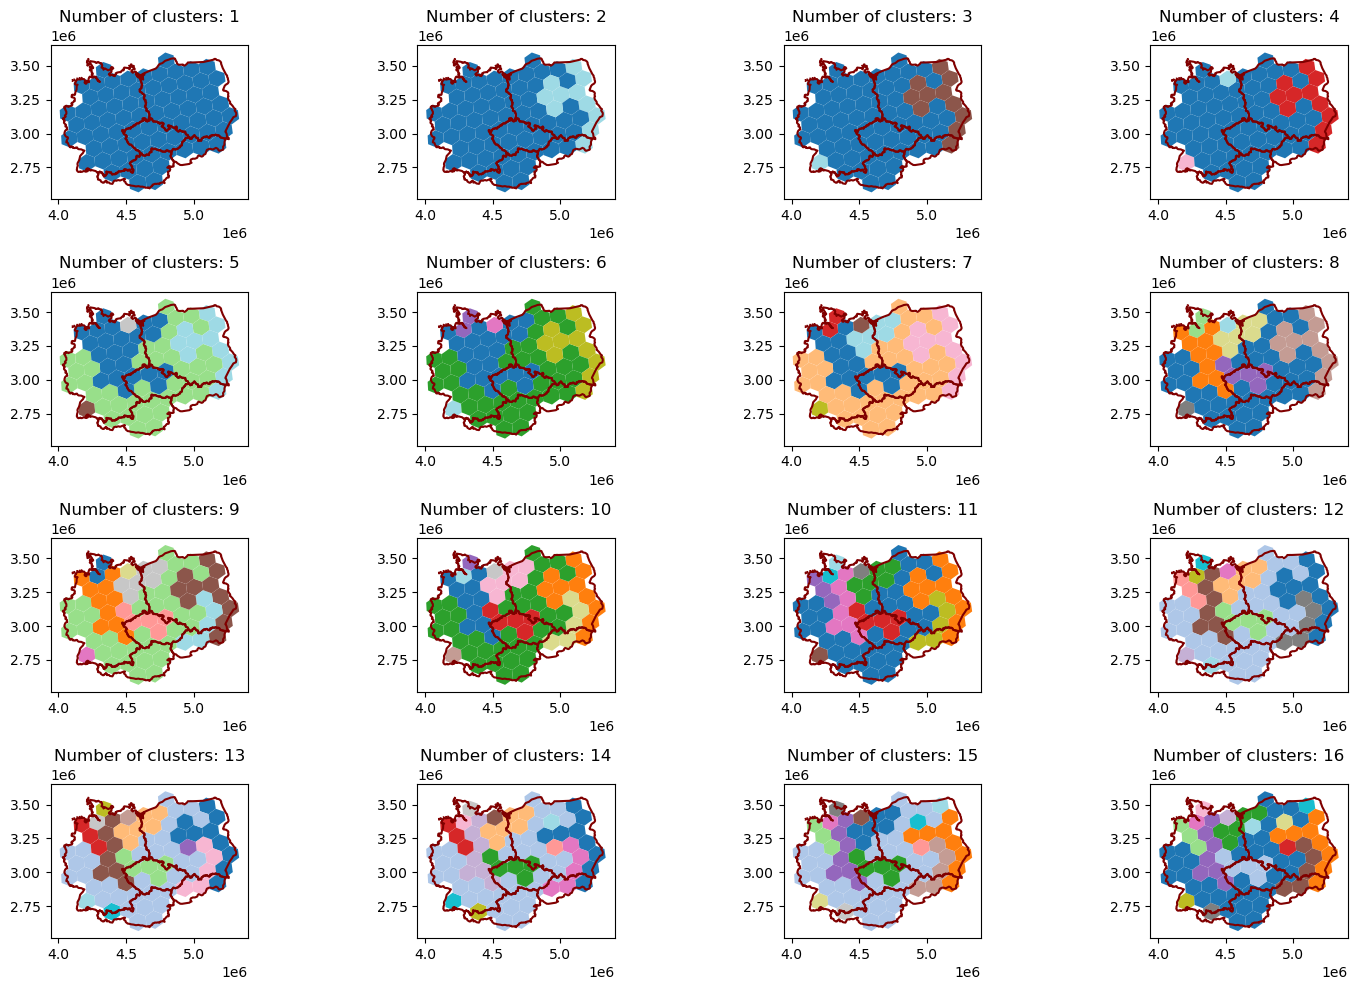

In [124]:
plot_cluster_maps(show_borders=True)

# Triangulation & Voronoi

Retrieve FUAs

In [196]:
fuas = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
fuas

eFUA_ID  UC_num UC_IDs   eFUA_name  Commuting Cntry_ISO   Cntry_name  \
0         1.0     1.0   5959       Herat        1.0       AFG  Afghanistan   
1       192.0     1.0   5964     Guzarah        1.0       AFG  Afghanistan   
2       354.0     1.0   5968    Shindand        0.0       AFG  Afghanistan   
3       505.0     1.0   5970  Qala i Naw        0.0       AFG  Afghanistan   
4       648.0     1.0   5973       Farah        1.0       AFG  Afghanistan   
...       ...     ...    ...         ...        ...       ...          ...   
9026   1739.0     1.0   4191    Triangle        0.0       ZWE     Zimbabwe   
9027   1908.0     1.0   4206   Glenclova        0.0       ZWE     Zimbabwe   
9028   2062.0     1.0   4222     Bindura        1.0       ZWE     Zimbabwe   
9029   2137.0     1.0   4236   Marondera        1.0       ZWE     Zimbabwe   
9030   2211.0     1.0   4329      Mutare        1.0       ZWE     Zimbabwe   

      FUA_area  UC_area     FUA_p_2015      UC_p_2015    Com_p_2015  \
0        139.0     60.0  888811.175807  844574.564331  44236.611476   
1         32.0     16.0  169489.573231  160204.260864   9285.312366   
2         12.0     12.0  147553.403870  147553.403870      0.000000   
3          3.0      3.0   79809.722656   79809.722656      0.000000   
4         32.0     16.0  131508.797060  122843.460327   8665.336733   
...        ...      ...            ...            ...           ...   
9026       5.0      5.0   61859.251465   61859.251465      0.000000   
9027       4.0      4.0  158476.038086  158476.038086      0.000000   
9028      54.0     16.0  109737.644325   74992.162598  34745.481728   
9029      23.0     12.0   61332.544647   52538.743042   8793.801605   
9030      70.0     30.0  176620.319862  159616.356934  17003.962929   

                                               geometry  
0     MULTIPOLYGON (((5529000 4155000, 5531000 41550...  
1     MULTIPOLYGON (((5541000 4139000, 5542000 41390...  
2     MULTIPOLYGON (((5573000 4030000, 5574000 40300...  
3     MULTIPOLYGON (((5592000 4221000, 5590000 42210...  
4     MULTIPOLYGON (((5607000 3923000, 5608000 39230...  
...                                                 ...  
9026  MULTIPOLYGON (((3023000 -2577000, 3021000 -257...  
9027  MULTIPOLYGON (((3033000 -2449000, 3032000 -244...  
9028  MULTIPOLYGON (((3053000 -2126000, 3054000 -212...  
9029  MULTIPOLYGON (((3067000 -2235000, 3065000 -223...  
9030  MULTIPOLYGON (((3161000 -2326000, 3162000 -232...  

[9031 rows x 13 columns]

In [197]:
target_countries = ['DEU', 'CZE', 'AUT', 'POL', 'SVK']

In [198]:
fuas = fuas[fuas.Cntry_ISO.isin(target_countries)]
fuas = fuas.to_crs(epsg=3035)
fuas.explore()

In [199]:
triangulation = graph.Graph.build_triangulation(fuas.centroid, method="gabriel", )

In [200]:
triangulation.explore(fuas.centroid)

Code from `05_cities.ipynb`

In [201]:
%%time
regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')
mapping = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
results = []

for region_id in regions.index:
    
    region_buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_v10.pq')
    
    # assign polygons to only one fua
    inp, res = region_buildings.sindex.query(fuas.geometry, predicate='intersects')
    # polygons should be assigned to only one fua
    duplicated = pd.Series(res).duplicated()
    inp = inp[~duplicated]
    res = res[~duplicated]
    
    # keep only fua buildings and record  fua 'country', 'city', 'population'
    region_buildings = region_buildings.iloc[res]
    region_buildings.loc[:, ['city', 'country', 'population']] = fuas.iloc[inp, [3, 5, 9]].values

    results.append(region_buildings)

all_fua_buildings = pd.concat(results, ignore_index=True)

CPU times: user 1min 54s, sys: 5.34 s, total: 1min 59s
Wall time: 1min 50s


In [202]:
level = 7
subset = all_fua_buildings[['country', 'city', 'final_without_noise']]
    
if level < 7:
    subset.loc[:, 'final_without_noise'] = subset.final_without_noise.map(mapping[level].to_dict())


res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
res = res.unstack(-1).fillna(0).astype(int)

# normalise based on counts
# note: normalisation can be based on building area too
X = res.values / res.sum(axis=1).values[:, np.newaxis]

In [203]:
X

array([[0.00416972, 0.00747479, 0.0188178 , ..., 0.        , 0.        ,
        0.        ],
       [0.01270188, 0.00740242, 0.03581763, ..., 0.00338156, 0.00154778,
        0.0044751 ],
       [0.01198964, 0.00763254, 0.02885436, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01243708, 0.02860529, 0.00623317, ..., 0.00103886, 0.00185825,
        0.        ],
       [0.01163287, 0.00616433, 0.00758029, ..., 0.00986292, 0.00939907,
        0.0064817 ],
       [0.0067825 , 0.01735432, 0.0058654 , ..., 0.009302  , 0.00321488,
        0.00287223]], shape=(136, 110))

In [204]:
res

final_without_noise   1     2     3     4     5     6    7    8    9    10   \
country city                                                                  
AUT     Graz          733  1314  3308   842  1905   654    0    0    0  272   
        Innsbruck     755   440  2129   631   742   263    0    0    0    0   
        Klagenfurt    787   501  1894  1136   450   271    0    0    0    0   
        Linz         2342  1651  2557  1702   900  1298    0    0    0  364   
        Salzburg     1121   776  1725  1179   770    99    0    0    0  140   
...                   ...   ...   ...   ...   ...   ...  ...  ...  ...  ...   
SVK     Bratislava   3054  6101  2788  1727   951  3116   70    0    0  359   
        Košice       2727  1317   905   564    41   608    0    0    0   90   
        Prešov        850  1955   426   300   239   250    0    0    0    4   
        Trnava        953   505   621   581   235   533  124    0    0  134   
        Žilina        673  1722   582   270   500  1044    0    0    0   86   

final_without_noise  ...   101  102  103  104   105   106   107  108   109  \
country city         ...                                                     
AUT     Graz         ...   776  128  478   19   512   432  1493    0     0   
        Innsbruck    ...   156   21  315    0   335   813  3318  201    92   
        Klagenfurt   ...   201   16    0    0   381   358  1577    0     0   
        Linz         ...  1594  339  507  138   477   680  2047   74     0   
        Salzburg     ...   909  136  680    0  1257   395  2181   87     0   
...                  ...   ...  ...  ...  ...   ...   ...   ...  ...   ...   
SVK     Bratislava   ...  2196  652  316  457   225  2535  2867  493  2176   
        Košice       ...   541  464   98  278   122   613   342    0   270   
        Prešov       ...    41    0   35   52     2   307   383   71   127   
        Trnava       ...   281   63    0  222   194   733   288  808   770   
        Žilina       ...   280  284    0    0    33   528   153  923   319   

final_without_noise   110  
country city               
AUT     Graz            0  
        Innsbruck     266  
        Klagenfurt      0  
        Linz            0  
        Salzburg        0  
...                   ...  
SVK     Bratislava   1698  
        Košice         12  
        Prešov          0  
        Trnava        531  
        Žilina        285  

[136 rows x 110 columns]

In [207]:
%%time
agg = cluster.AgglomerativeClustering(n_clusters=20, connectivity=triangulation.sparse, metric=distance.braycurtis, linkage='single')
agg.fit(X)

CPU times: user 4.75 ms, sys: 16 μs, total: 4.77 ms
Wall time: 4.35 ms


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse array of dtype 'float64'
	with 548 stored elements and shape (136, 136)>,
                        linkage='single',
                        metric=<function braycurtis at 0x70067a8f20c0>,
                        n_clusters=20)

In [208]:
fuas.explore(column=agg.labels_, categorical=True, cmap="tab20")

# Cluster variants

In [209]:
from spopt.region import SA3, AZP, MaxPHeuristic

In [210]:
df = pd.DataFrame(X, index=fuas.index)

In [215]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=6, extraction='leaf', metric=distance.braycurtis, linkage='single')
clusterer.solve()

In [216]:
fuas.explore(column=clusterer.labels_, categorical=True)

In [19]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])
dissolved_fuas

geometry  eFUA_ID  UC_num  \
0  MULTIPOLYGON (((4957228.92 3133188.246, 495815...    140.0     2.0   
1  MULTIPOLYGON (((4141628.013 2734164.187, 41435...     44.0     2.0   
2  MULTIPOLYGON (((4657862.394 2634214.876, 46588...    199.0     1.0   

      UC_IDs eFUA_name  Commuting Cntry_ISO Cntry_name  FUA_area  UC_area  \
0  2907;2914  Szczecin        1.0       POL     Poland     684.0     97.0   
1  2245;2235   Heerlen        1.0       DEU    Germany     532.0    111.0   
2       2885  Salzburg        1.0       AUT    Austria     368.0     46.0   

      FUA_p_2015      UC_p_2015     Com_p_2015  
0  486245.297774  325875.429302  160369.868472  
1  544558.664806  293165.160751  251393.504054  
2  261062.845268  140052.170959  121010.674308

In [20]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=2000, segment=1000)

/tmp/ipykernel_76104/777305694.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=2000, segment=1000)


In [21]:
voronoi

geometry
0  POLYGON ((5197853.468 2649887.992, 5170307.072...
1  POLYGON ((4584100.674 3538869.284, 4584246.358...
2  POLYGON ((4515629.662 2622061.758, 4516059.07 ...

<Axes: >

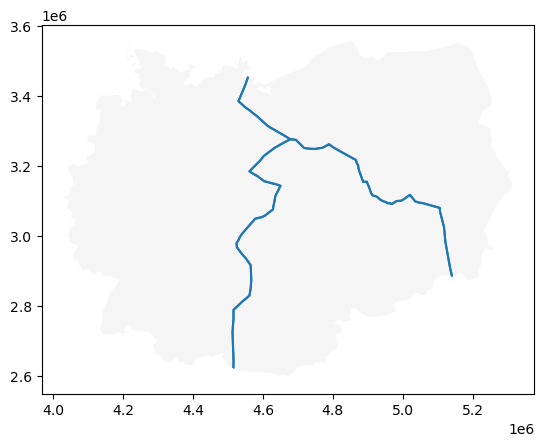

In [22]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [23]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=6, extraction='eom', metric=distance.braycurtis, linkage='average')
clusterer.solve()

In [24]:
fuas.explore(column=clusterer.labels_, categorical=True)

In [25]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [26]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)

/tmp/ipykernel_76104/271934043.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)


<Axes: >

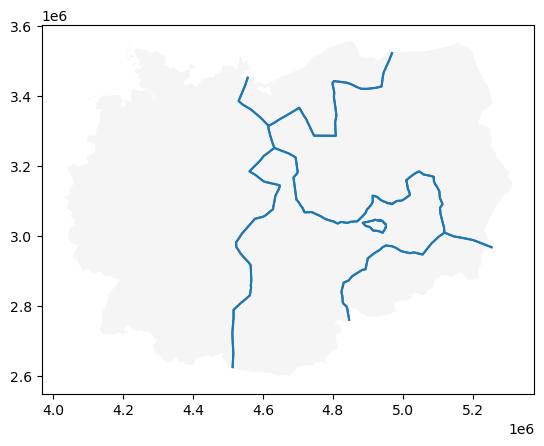

In [27]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [101]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=5, extraction='leaf', metric=distance.braycurtis, linkage='average')
clusterer.solve()

In [102]:
fuas.explore(column=clusterer.labels_, categorical=True)

In [103]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [104]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)

/tmp/ipykernel_76104/271934043.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)


In [105]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).explore()
aoi.explore(m=ax, color="whitesmoke")

In [33]:
clusterer = AZP(df, triangulation.to_W(), attrs_name=df.columns, n_clusters=9)
clusterer.solve()

In [34]:
fuas.explore(column=clusterer.labels_, categorical=True)

In [35]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)

In [36]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)

/tmp/ipykernel_76104/2257978305.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)


<Axes: >

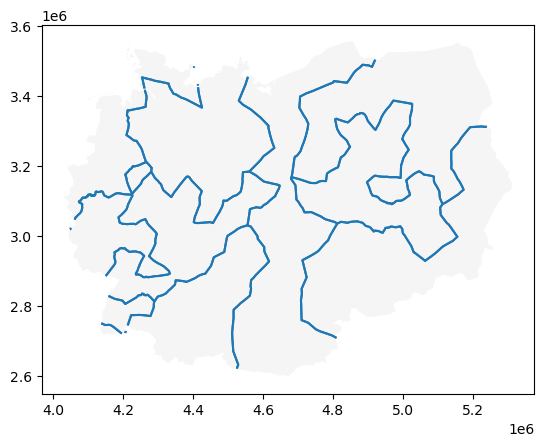

In [37]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [38]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=10, extraction='leaf', metric=distance.braycurtis, linkage='single')
clusterer.solve()

In [39]:
fuas.explore(column=clusterer.labels_, categorical=True)

In [40]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [41]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)

/tmp/ipykernel_76104/2257978305.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)


In [51]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).explore()
aoi.explore(m=ax, color="whitesmoke")

In [43]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=9, extraction='leaf', metric=distance.braycurtis, linkage='average')
clusterer.solve()

In [44]:
fuas.explore(column=clusterer.labels_, categorical=True)

In [45]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [46]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1500, segment=100)

/tmp/ipykernel_76104/3152602596.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1500, segment=100)


<Axes: >

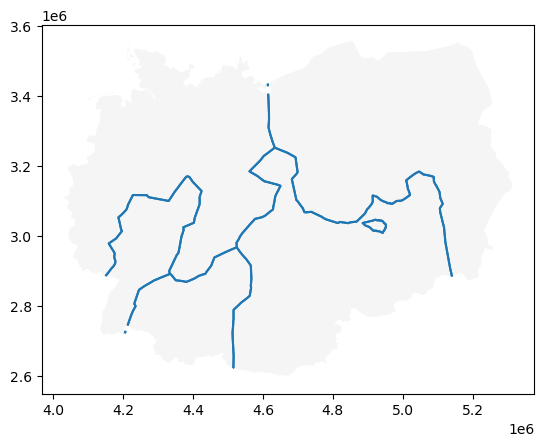

In [47]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")